# Ball Challenge

In [2]:
from typing import cast
from pathlib import Path
from functools import partial

import torch
from torch.nn.functional import softmax
from torch.nn import Sequential as torchSequential
from torch.utils.data import random_split
from typing import cast
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use("seaborn-v0_8-whitegrid")

from ballchallenge.model import BallChallengeModel
from ballchallenge.accelerometer_dataset import AccelerometerDataset, AccelerometerDatasetWithPointLabels
from ballchallenge.training import run_training, run_training_for_position
from elasticai.creator.file_generation.on_disk_path import OnDiskPath
from elasticai.creator.nn.sequential import Sequential
from elasticai.creator.vhdl.system_integrations.firmware_env5 import FirmwareENv5

from ballchallenge.model_builder import ModelBuilder
from ballchallenge.accelerometer_dataset import AccelerometerDataset
from ballchallenge.training import run_training


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_ROOT = Path("../data")
GRID_SIZE = (10, 10)

## Load Training and Test Data

In [3]:
def flat_labels(labels: torch.Tensor) -> torch.Tensor:
        return labels.flatten(start_dim=1)

    def downsample(samples: torch.Tensor, factor: int) -> torch.Tensor:
        return samples[:,:,::factor]


def downsample_and_substract_mean(samples: torch.Tensor, factor):
    return samples[:,:, ::factor] - samples[:, :, ::factor].mean(dim=2, keepdim=True)


def load_heatmap_dataset() -> AccelerometerDataset:
   
    return AccelerometerDataset(
        dataset_root=DATASET_ROOT,
        grid_size=GRID_SIZE,
        x_position_range=(0, 2),
        y_position_range=(0, 2),
        label_std=0.3,
        transform_samples=partial(downsample_and_substract_mean, factor=4),
        transform_labels=flat_labels,
    )

def load_point_dataset():
    return AccelerometerDatasetWithPointLabels(
        dataset_root=DATASET_ROOT,
        transform_samples=partial(downsample_and_substract_mean, factor=4),
    )

ds = load_point_dataset()
ds_train, ds_test = random_split(ds, lengths=[0.75, 0.25], generator=torch.Generator().manual_seed(42))
input_shape = cast(tuple[int, int], tuple(ds_train[:][0].shape[1:]))

print("Train Samples:", len(ds_train))
print("Test Samples:", len(ds_test))

input_shape = cast(tuple[int, int], tuple(ds_train[:][0].shape[1:]))
print("Sample Shape:", input_shape)

Train Samples: 43
Test Samples: 14
Sample Shape: (3, 250)


## Create Model

In [4]:
def create_heat_map_model(input_shape: tuple[int, int]) -> Sequential:
    model_builder = ModelBuilder(total_bits=8, frac_bits=4, input_shape=input_shape)
    
    model_builder.add_conv1d(filters=1, kernel_size=64).add_hard_tanh()
    model_builder.add_conv1d(filters=1, kernel_size=64).add_hard_tanh()
    model_builder.add_conv1d(filters=1, kernel_size=96).add_hard_tanh()
    model_builder.add_flatten()
    model_builder.add_linear(output_units=GRID_SIZE[0] * GRID_SIZE[1])

    return model_builder.build_model()

def create_position_model(input_shape: tuple[int, int]) -> torch.nn.Module:
    conv = torch.nn.Conv1d
    act = torch.nn.ReLU
    flatten = torch.nn.Flatten
    linear = torch.nn.Linear
    in_length = input_shape[1]
    return torchSequential(
        conv(in_channels=3, out_channels=1, kernel_size=64),
        act(),
        conv(in_channels=1, out_channels=1, kernel_size=64),
        act(),
        conv(in_channels=1, out_channels=1, kernel_size=64),
        flatten(),
        linear(in_features=(in_length + 3* ( 1 - 64)), out_features=2)
    )

model = create_position_model(input_shape)
print("Model Parameters:", sum(param.numel() for param in model.parameters()))

Model Parameters: 447


## Train Model

## Evaluate Trained Model

### Training History

start training
[epoch 1/800] train_loss: 1.3019 test_loss: 1.0768 
[epoch 2/800] train_loss: 1.2994 test_loss: 1.0739 
[epoch 3/800] train_loss: 1.2880 test_loss: 1.0711 
[epoch 4/800] train_loss: 1.2912 test_loss: 1.0684 
[epoch 5/800] train_loss: 1.2787 test_loss: 1.0657 
[epoch 6/800] train_loss: 1.2860 test_loss: 1.0630 
[epoch 7/800] train_loss: 1.2798 test_loss: 1.0602 
[epoch 8/800] train_loss: 1.2685 test_loss: 1.0575 
[epoch 9/800] train_loss: 1.2998 test_loss: 1.0548 
[epoch 10/800] train_loss: 1.2891 test_loss: 1.0522 
[epoch 11/800] train_loss: 1.2716 test_loss: 1.0497 
[epoch 12/800] train_loss: 1.2475 test_loss: 1.0473 
[epoch 13/800] train_loss: 1.2584 test_loss: 1.0449 
[epoch 14/800] train_loss: 1.2626 test_loss: 1.0426 
[epoch 15/800] train_loss: 1.2635 test_loss: 1.0404 
[epoch 16/800] train_loss: 1.2706 test_loss: 1.0383 
[epoch 17/800] train_loss: 1.2588 test_loss: 1.0362 
[epoch 18/800] train_loss: 1.2488 test_loss: 1.0342 
[epoch 19/800] train_loss: 1.2501 test_l

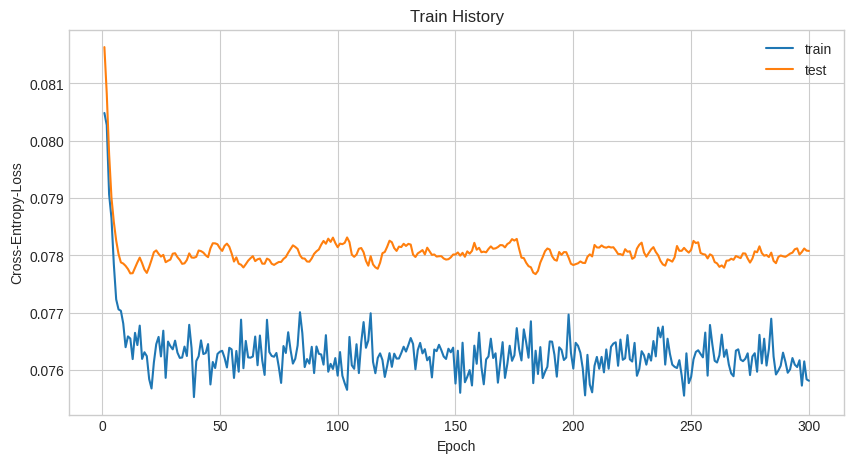

In [5]:
history = run_training_for_position(
    model=model,
    ds_train=ds_train,
    ds_test=ds_test,
    batch_size=8,
    epochs=800,
    learning_rate=1e-4,
    device=DEVICE
)
model.float()
model.eval()
model.to("cpu")

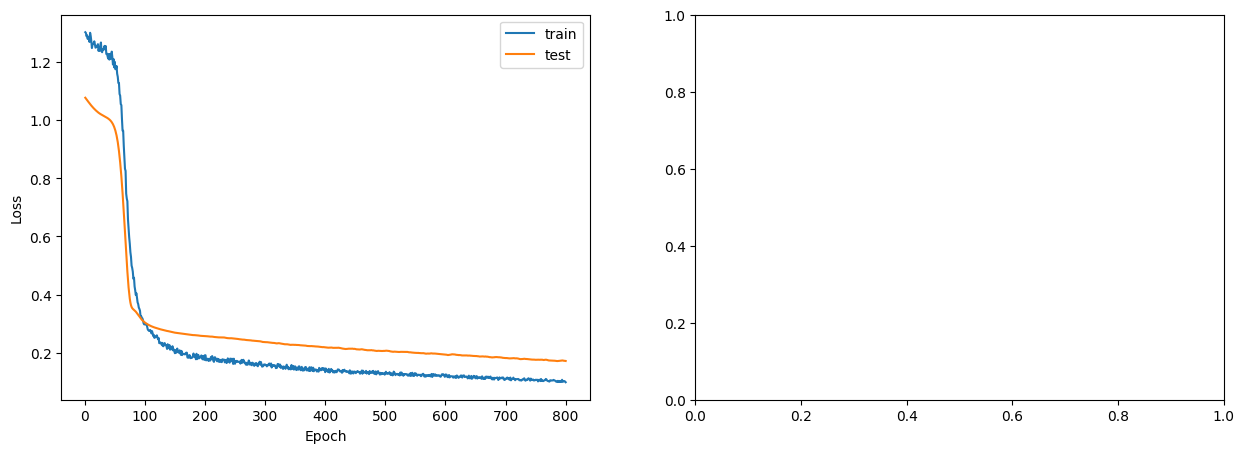

In [6]:
def plot_training_history() -> None:
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    ax.plot(history.train["epoch"], history.train["loss"], label="train")
    ax.plot(history.test["epoch"], history.test["loss"], label="test")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Cross-Entropy-Loss")
    ax.set_title("Train History")
    ax.legend()

axs[0].plot(history.train["epoch"], history.train["loss"], label="train")
axs[0].plot(history.test["epoch"], history.test["loss"], label="test")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

if "accuracy" in history.train and "accuracy" in history.test:
    axs[1].plot(history.train["epoch"], history.train["accuracy"], label="train")
    axs[1].plot(history.test["epoch"], history.test["accuracy"], label="test")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

In [12]:
def render_heat_map_target_and_prediction(sample, target):
    prediction = softmax(model(sample).detach(), dim=1).view(*GRID_SIZE[::-1])
    target = target.view(*GRID_SIZE[::-1])
    
    _, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    sns.heatmap(prediction, cmap="hot", square=True, ax=axs[0])
    axs[0].set_title("Prediction")
    sns.heatmap(target, cmap="hot", square=True, ax=axs[1])
    axs[1].set_title("Target")

distances = []
targets = []
predictions = []

for (s, t) in ds:
    p = model(s)[0]
    predictions.append(p.detach().numpy())
    targets.append(t.detach().numpy())
    distance = torch.nn.functional.pairwise_distance(t, p, p=2.0, eps=0).detach().numpy()
    distances.append(distance)

df = pd.DataFrame.from_dict({'targets': targets, 'predictions': predictions})
print(df)

[array([1.0588236, 1.3036935], dtype=float32), array([0.9015048, 1.240766 ], dtype=float32), array([1.247606 , 1.3214774], dtype=float32), array([0.76880985, 0.9042408 ], dtype=float32), array([1.4309165 , 0.97948015], dtype=float32), array([0.6798906, 1.2544459], dtype=float32), array([0.85636115, 0.84541726], dtype=float32), array([1.0889193, 1.0150479], dtype=float32), array([0.6963064, 1.0574555], dtype=float32), array([0.8946648 , 0.90697676], dtype=float32), array([1.0560875, 1.4569083], dtype=float32), array([0.42407662, 0.9302326 ], dtype=float32), array([0.8931507 , 0.86849314], dtype=float32), array([1.6128591, 1.0957593], dtype=float32), array([0.40218878, 0.3529412 ], dtype=float32), array([1.5088919, 1.3652531], dtype=float32), array([0.39398086, 0.13953489], dtype=float32), array([1.2      , 1.8671232], dtype=float32), array([1.0753424, 1.039726 ], dtype=float32)]
                     targets               predictions
0     [1.0588236, 1.3036935]    [1.1778371, 1.1779923]

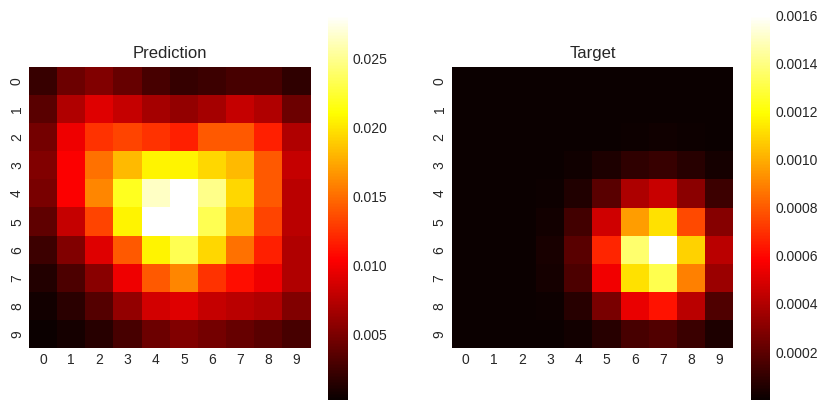

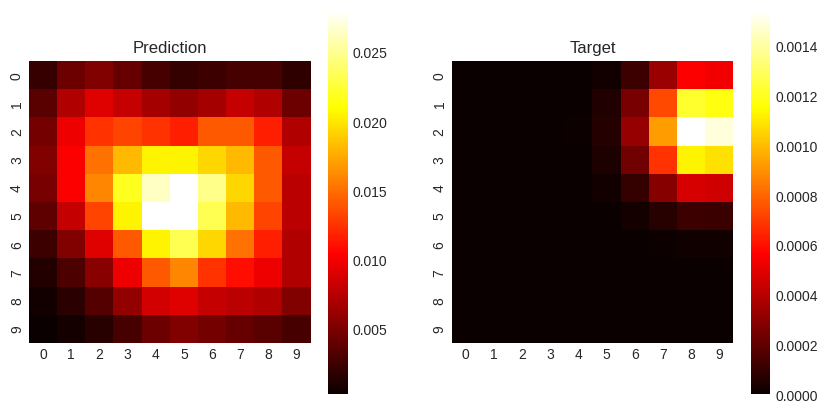

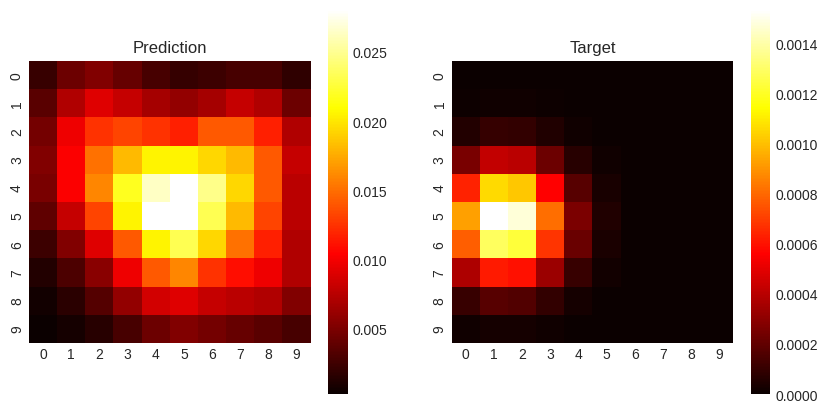

In [ ]:
for i in range(3):
    render_target_and_prediction(ds_train, sample_idx=i)

#### On Testing Set

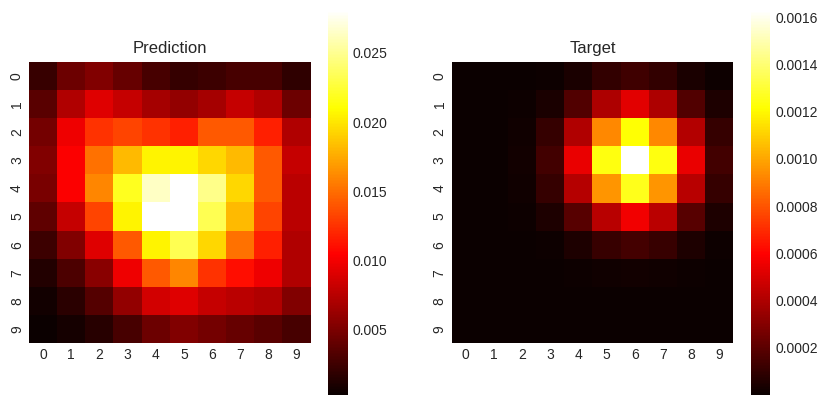

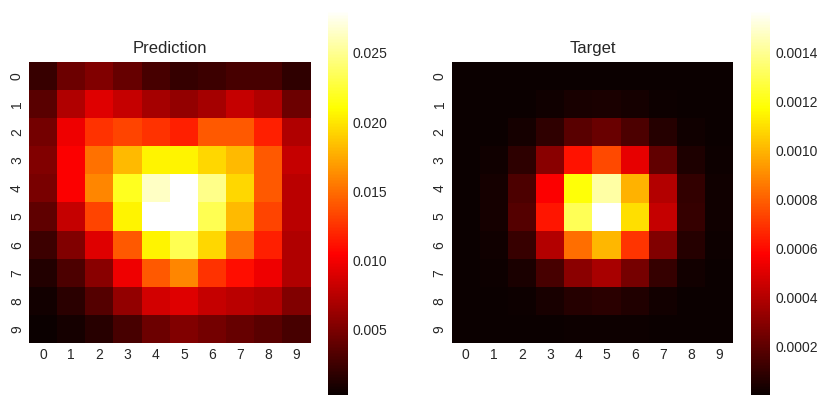

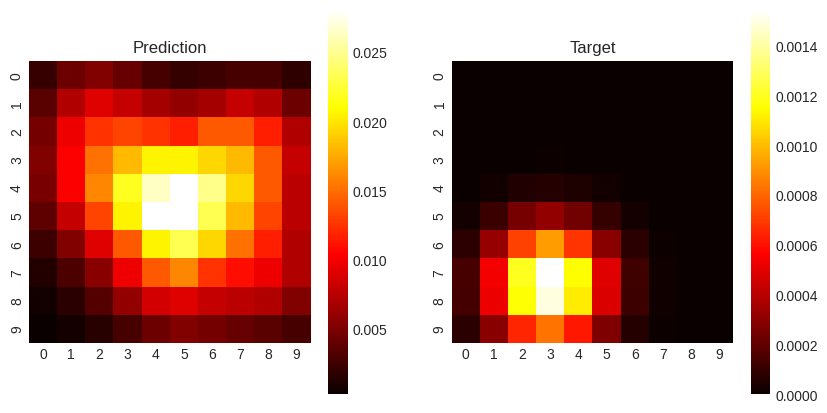

In [8]:
for i in range(3):
    render_target_and_prediction(ds_test, sample_idx=i)

## Save Hardware Implementation

In [ ]:
path = OnDiskPath("build")

hw_design = model.create_design("ball_throw")

channels, signal_length = ds_train[0][0].shape
total_length = channels * signal_length

firmware = FirmwareENv5(
    network=hw_design,
    x_num_values=total_length,
    y_num_values=GRID_SIZE[0] * GRID_SIZE[1],
    skeleton_version="v2",
    id=666
)
firmware.save_to(path)

## Additional Section

### Mean Label of the Dataset

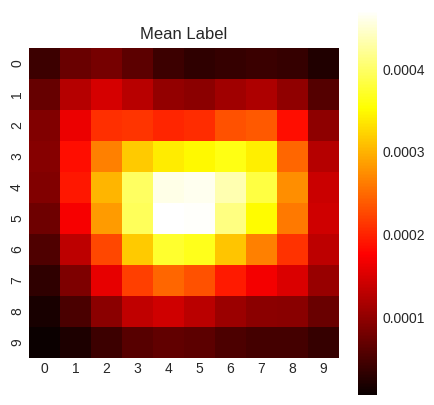

In [10]:
def plot_dataset_mean_label() -> None:
    _, labels = ds[:]
    mean_label = labels.mean(dim=0)
    
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    sns.heatmap(mean_label.view(GRID_SIZE), square=True, cmap="hot", ax=ax)
    ax.set_title("Mean Label")
    

plot_dataset_mean_label()